In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

In [6]:
set_name = 'LCI'

In [7]:
%%sql

DROP TYPE IF EXISTS expansion;
CREATE TYPE expansion AS ENUM ('KTK', 'LCI', 'WOE', 'LTR', 'MOM', 'SIR', 'ONE', 'BRO', 'DMU', 'HBG', 'SNC', 'NEO', 'VOW', 'MID', 'AFR', 'STX', 'KHM');
DROP TYPE IF EXISTS event_type;
CREATE TYPE event_type AS ENUM ('PremierDraft', 'TradDraft', 'Sealed', 'TradSealed');
DROP TYPE IF EXISTS rank;
CREATE TYPE rank AS ENUM ('silver', 'bronze', 'None', 'none', 'gold', 'platinum', 'diamond', 'mythic');
DROP TYPE IF EXISTS color;
CREATE TYPE color AS ENUM ('RG', 'UBG', 'WUB', 'UBR', 'WUBG', 'BG', 'WG', 'WBG', 'WUBRG', 'UR', 'UB', 'WBR', 'WRG', 'None', 'BR', 'WUBR', 'G', 'WR', 'W', 'WU', 'WB', 'WUR', 'WUG', 'WBRG', 'BRG', 'U', 'URG', 'UBRG', 'UG', 'B', 'R', 'WURG');

,Success


In [8]:
%%sql

DROP TABLE IF EXISTS game;

# https://www.17lands.com/history/<draft_id>/<match_number - 1>/<game_number - 1>
CREATE TABLE game (
    expansion expansion NOT NULL,
    event_type event_type NOT NULL,
    draft_id VARCHAR NOT NULL,
    draft_time TIMESTAMP_S NOT NULL,
    build_index TINYINT NOT NULL,
    match_number TINYINT NOT NULL,
    game_number TINYINT NOT NULL,
    rank rank,
    opp_rank rank,
    main_colors color,
    splash_colors color,
    on_play BOOLEAN NOT NULL,
    num_mulligans TINYINT NOT NULL,
    opp_num_mulligans TINYINT NOT NULL,
    opp_colors color,
    num_turns TINYINT NOT NULL,
    won BOOLEAN NOT NULL,
    user_n_games_bucket INTEGER NOT NULL,
    user_game_win_rate_bucket DOUBLE,
)

,Success


In [9]:
%%sql

INSERT INTO
    game
BY NAME
SELECT
    expansion, event_type, draft_id, draft_time, build_index, match_number, game_number, rank, opp_rank, main_colors, splash_colors, on_play, num_mulligans, opp_num_mulligans, opp_colors, num_turns, won, user_n_games_bucket, user_game_win_rate_bucket
FROM
    # 'https://17lands-public.s3.amazonaws.com/analysis_data/game_data/game_data_public.{{ set_name }}.PremierDraft.csv.gz'
    '~/Downloads/game_data_public.{{ set_name }}.PremierDraft.csv.gz'

,Success


In [10]:
%%sql

# DROP INDEX IF EXISTS game_draft_match_game;
# CREATE UNIQUE INDEX game_draft_match_game ON game (draft_id, match_number, game_number);

DROP INDEX IF EXISTS game_draft;
CREATE INDEX game_draft ON game (draft_id);

DROP INDEX IF EXISTS game_rank;
CREATE INDEX game_rank ON game (rank);

DROP INDEX IF EXISTS game_main_colors;
CREATE INDEX game_main_colors ON game (main_colors);

DROP INDEX IF EXISTS game_splash_colors;
CREATE INDEX game_splash_colors ON game (splash_colors);

DROP INDEX IF EXISTS game_on_play;
CREATE INDEX game_on_play ON game (on_play);

DROP INDEX IF EXISTS game_user_n_games_bucket;
CREATE INDEX game_user_n_games_bucket ON game (user_n_games_bucket);

DROP INDEX IF EXISTS game_user_win_rate_bucket;
CREATE INDEX game_user_win_rate_bucket ON game (user_game_win_rate_bucket);

,Success


In [11]:
%%sql

DROP TABLE IF EXISTS draft;

# https://www.17lands.com/history/<draft_id>/<match_number - 1>/<game_number - 1>
CREATE TABLE draft (
    expansion expansion NOT NULL,
    event_type event_type NOT NULL,
    draft_id VARCHAR NOT NULL,
    draft_time TIMESTAMP_S NOT NULL,
    rank rank,
    
    event_match_wins TINYINT NOT NULL,
    event_match_losses TINYINT NOT NULL,
    
    pack_number TINYINT NOT NULL,
    pick_number TINYINT NOT NULL,

    pick VARCHAR NOT NULL,

    # the number of games the user played with the picked card in their maindeck, divided by the total number of games the user played (with that draft pool).
    pick_maindeck_rate DOUBLE NOT NULL,
    # the number of games the user played with the picked card in their sideboard, divided by the total number of games the user played (with that draft pool).
    pick_sideboard_in_rate DOUBLE NOT NULL,
    
    user_n_games_bucket INTEGER NOT NULL,
    user_game_win_rate_bucket DOUBLE
)

,Success


In [12]:
%%sql

INSERT INTO
    draft
BY NAME
SELECT
    expansion,
    event_type,
    draft_id,
    draft_time,
    rank,
    event_match_wins,
    event_match_losses,
    pack_number,
    pick_number,
    pick,
    pick_maindeck_rate,
    pick_sideboard_in_rate,
    user_n_games_bucket,
    user_game_win_rate_bucket,
FROM
    # 'https://17lands-public.s3.amazonaws.com/analysis_data/draft_data/draft_data_public.{{ set_name }}.PremierDraft.csv.gz'
    '~/Downloads/draft_data_public.{{ set_name }}.PremierDraft.csv.gz'

,Success


In [13]:
%%sql

DROP INDEX IF EXISTS draft_draft_pack_pick;
CREATE UNIQUE INDEX draft_draft_pack_pick ON draft (draft_id, pack_number, pick_number);

DROP INDEX IF EXISTS draft_draft;
CREATE INDEX draft_draft ON draft (draft_id);

DROP INDEX IF EXISTS draft_rank;
CREATE INDEX draft_rank ON draft (rank);

DROP INDEX IF EXISTS draft_user_n_games_bucket;
CREATE INDEX draft_user_n_games_bucket ON draft (user_n_games_bucket);

DROP INDEX IF EXISTS draft_user_win_rate_bucket;
CREATE INDEX draft_user_win_rate_bucket ON draft (user_game_win_rate_bucket);

,Success


In [14]:
import requests

response = requests.get('https://api.scryfall.com/bulk-data/oracle-cards')
response.raise_for_status()
scryfall_oracle_cards_download_uri = response.json()['download_uri']
del response

scryfall_oracle_cards_download_uri

'https://data.scryfall.io/oracle-cards/oracle-cards-20240125220205.json'

In [15]:
%%sql

DROP TABLE IF EXISTS scryfall_oracle_cards;
# CREATE TABLE scryfall_oracle_cards AS FROM read_json_auto('{{ scryfall_oracle_cards_download_uri }}')
# 'https://data.scryfall.io/oracle-cards/oracle-cards-20240109100132.json'
CREATE TABLE scryfall_oracle_cards AS FROM read_json_auto('~/Downloads/oracle-cards-20240109100132.json')

,Success


In [16]:
%%sql

DROP INDEX IF EXISTS card_id;
CREATE UNIQUE INDEX card_id ON scryfall_oracle_cards (id);

DROP INDEX IF EXISTS card_name;
CREATE INDEX card_name ON scryfall_oracle_cards (name);

DROP INDEX IF EXISTS card_set;
CREATE INDEX card_set ON scryfall_oracle_cards (set);

,Success


In [17]:
# Verified win-rate is not normal distribution
# scipy.stats.normaltest(df['user_game_win_rate_bucket'])

df = %sql SELECT median(user_n_games_bucket) AS median_user_n_games_bucket, median(user_game_win_rate_bucket) AS median_user_game_win_rate_bucket FROM game

user_n_games_threshold = df['median_user_n_games_bucket'][0]
user_game_win_rate_threshold = df['median_user_game_win_rate_bucket'][0]

print(f'user_n_games_threshold={user_n_games_threshold}, user_game_win_rate_threshold={user_game_win_rate_threshold}')

user_n_games_threshold=100.0, user_game_win_rate_threshold=0.54


In [18]:
%%sql win_rate_by_main_colors_num_turns <<

WITH wins_by_turns AS (
    SELECT
        main_colors,
        num_turns,
        round(COUNT(*) FILTER (WHERE won = True) / COUNT(*), 3) AS win_rate
    FROM game
    WHERE
        length(main_colors) = 2
        AND (num_turns BETWEEN 4 AND 16)
        AND user_game_win_rate_bucket >= {{ user_game_win_rate_threshold }}
        AND user_n_games_bucket >= {{ user_n_games_threshold }}
    GROUP BY main_colors, num_turns
)

SELECT *
FROM wins_by_turns
PIVOT (
    AVG(win_rate) FOR num_turns IN (4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)
) AS pivoted;

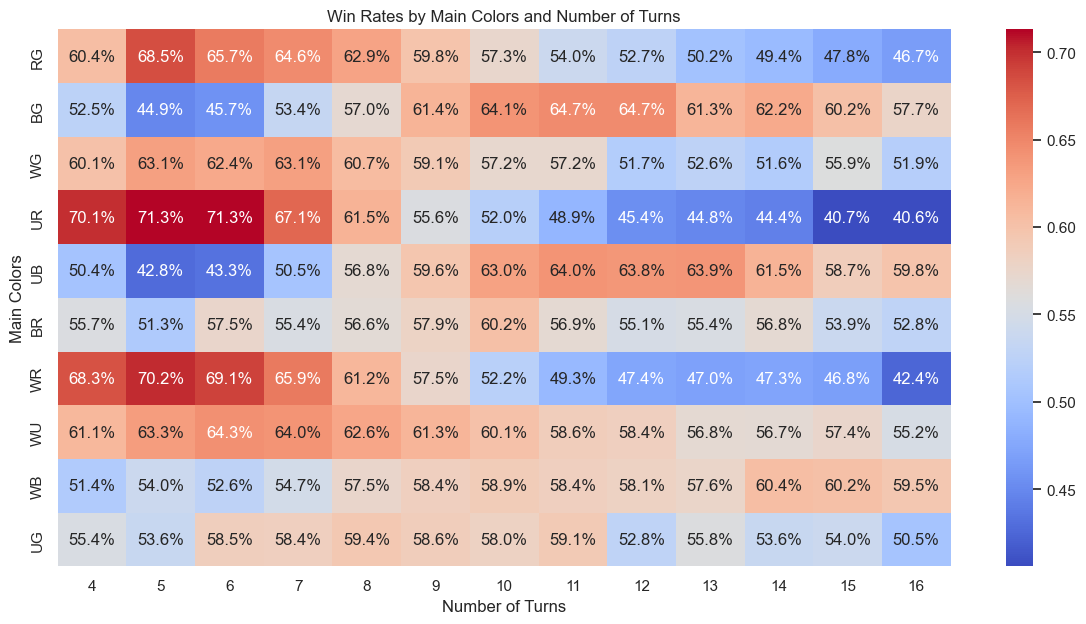

In [19]:
fig = plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.heatmap(win_rate_by_main_colors_num_turns.set_index('main_colors'), annot=True, fmt=".1%", cmap='coolwarm')
plt.tight_layout()
plt.xlabel('Number of Turns')
plt.ylabel('Main Colors')
plt.title('Win Rates by Main Colors and Number of Turns')
plt.show()

<Axes: title={'center': 'Main Colors Distribution'}, ylabel='count'>

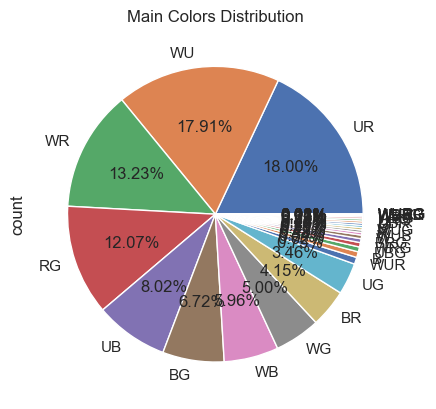

In [20]:
top_game = %sql SELECT main_colors, COUNT(*) AS count FROM game WHERE user_game_win_rate_bucket >= {{ user_game_win_rate_threshold }} AND user_n_games_bucket >= {{ user_n_games_threshold }} AND won = True GROUP BY main_colors ORDER BY count DESC
top_game.set_index('main_colors', inplace=True)
top_game.plot.pie(y='count', autopct='%.2f%%', title='Main Colors Distribution', legend=False)

TODO: Need to think Bayesian prior probability

M/R : UC : C = 1 : 3 : 10

LCI has 22 M and 64 R

In [21]:
%%sql result_df<<

WITH pick_counts AS(
    SELECT main_colors, pick, COUNT(*) AS count
    FROM draft d
    JOIN game g
    USING (draft_id)
    WHERE
        g.user_n_games_bucket >= {{ user_n_games_threshold }}
        AND g.user_game_win_rate_bucket >= {{ user_game_win_rate_threshold }}
        AND won = TRUE
        AND length(main_colors) = 2
        AND (
            (pack_number = 0 AND pick_number < 5)
            OR (pack_number = 1 AND pick_number < 3)
            OR (pack_number = 2 AND pick_number < 3)
        )
        AND pick_maindeck_rate = 1
    GROUP BY
        main_colors,
        pick
)
SELECT main_colors, pick, count
FROM pick_counts c1
WHERE
    count IN (
        SELECT count
        FROM pick_counts c2
        WHERE c2.main_colors = c1.main_colors
        ORDER BY count DESC
    )
ORDER BY main_colors, count DESC, pick

In [22]:
%%sql top_cards_df<<

SELECT p.pick, percentile, rarity, scryfall_uri, image_uris.large FROM (
    SELECT
        pick, percent_rank() OVER (ORDER BY SUM(count)) AS percentile
    FROM result_df
    GROUP BY pick
) AS p
JOIN scryfall_oracle_cards c
ON
    p.pick = c.name
    AND c.set = '{{ set_name|lower}}'
    AND list_contains(games, 'arena')
    AND set_type <> 'promo'
    AND digital = False
    AND promo_types IS NULL
ORDER BY percentile DESC

In [23]:
from IPython.display import display, HTML, Image

def url_to_image_html(path):
    return f'<a href="{path}"><img src="{path}" style="max-height:124px;"/>'

def url_website_html(row):
    return f'<a href="{row["scryfall_uri"]}">{row["pick"]}</a>'

formatters = {
    'large': url_to_image_html,
}

top_cards_df_formatted = top_cards_df.copy()

from IPython.utils import io

with io.capture_output() as _:
    top_cards_df_formatted["pick"] = top_cards_df.apply(url_website_html, axis=1)
    top_cards_df_formatted.drop(columns=["scryfall_uri"], inplace=True)

display(HTML(top_cards_df_formatted.loc[top_cards_df_formatted['rarity'] == 'common'].head(20).to_html(render_links=True, escape=False, float_format=lambda x: '%10.2f' % x, formatters=formatters)))
display(HTML(top_cards_df_formatted.loc[top_cards_df_formatted['rarity'] == 'uncommon'].head(10).to_html(render_links=True, escape=False, float_format=lambda x: '%10.2f' % x, formatters=formatters)))
display(HTML(top_cards_df_formatted.loc[top_cards_df_formatted['rarity'] == 'rare'].head(5).to_html(render_links=True, escape=False, float_format=lambda x: '%10.2f' % x, formatters=formatters)))
display(HTML(top_cards_df_formatted.loc[top_cards_df_formatted['rarity'] == 'mythic'].head(5).to_html(render_links=True, escape=False, float_format=lambda x: '%10.2f' % x, formatters=formatters)))

,pick,percentile,rarity,large
0,Waterwind Scout,1.00,common,
1,Abrade,1.00,common,
2,Oltec Cloud Guard,0.99,common,
3,Oaken Siren,0.99,common,
4,Miner's Guidewing,0.99,common,
5,Petrify,0.98,common,
8,Tinker's Tote,0.97,common,
9,Plundering Pirate,0.97,common,
11,Join the Dead,0.95,common,
12,Etali's Favor,0.95,common,


,pick,percentile,rarity,large
6,Zoetic Glyph,0.98,uncommon,
7,Spyglass Siren,0.98,uncommon,
10,Geological Appraiser,0.96,uncommon,
13,Staunch Crewmate,0.94,uncommon,
14,Ruin-Lurker Bat,0.94,uncommon,
22,Chupacabra Echo,0.91,uncommon,
23,"Captain Storm, Cosmium Raider",0.90,uncommon,
25,Deep-Cavern Bat,0.90,uncommon,
26,Belligerent Yearling,0.89,uncommon,
28,Dusk Rose Reliquary,0.89,uncommon,


,pick,percentile,rarity,large
49,Kitesail Larcenist,0.80,rare,
50,"Akal Pakal, First Among Equals",0.80,rare,
51,"Breeches, Eager Pillager",0.80,rare,
56,Magmatic Galleon,0.78,rare,
58,Subterranean Schooner,0.77,rare,


,pick,percentile,rarity,large
110,Bonehoard Dracosaur,0.55,mythic,
114,"Chimil, the Inner Sun",0.53,mythic,
128,Quintorius Kand,0.48,mythic,
131,Resplendent Angel,0.46,mythic,
141,The Skullspore Nexus,0.42,mythic,


In [24]:
# Define the custom lexicographic order
order = "WUBRG"

# Define a function to compare two strings based on the order
def compare(s1, s2):
  # Loop through the characters of the shorter string
  for i in range(min(len(s1), len(s2))):
    # If the characters are different, compare their positions in the order
    if s1[i] != s2[i]:
      return order.index(s1[i]) - order.index(s2[i])
  # If the strings are equal up to the shorter length, compare their lengths
  return len(s1) - len(s2)

# Define a function to sort an array based on the compare function
def custom_sort(array):
  # Use a selection sort algorithm
  for i in range(len(array)):
    # Find the minimum element in the remaining array
    min_index = i
    for j in range(i + 1, len(array)):
      if compare(array[j], array[min_index]) < 0:
        min_index = j
    # Swap the minimum element with the current element
    array[i], array[min_index] = array[min_index], array[i]
  # Return the sorted array
  return array

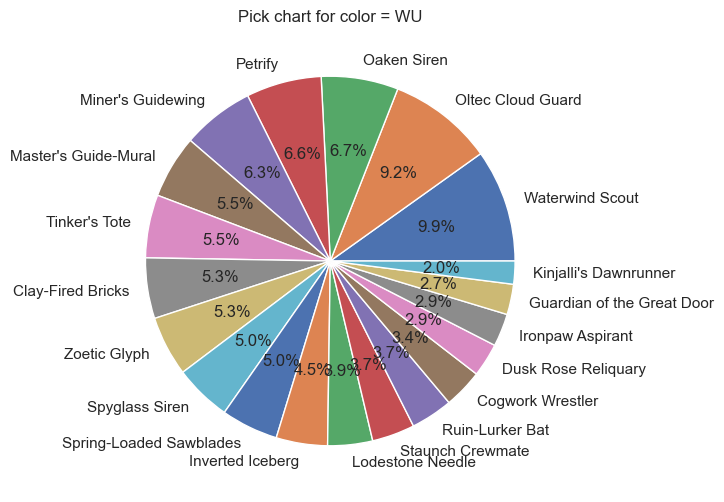

,pick,percentile,rarity,image
0,Waterwind Scout,1.00,common,
1,Oltec Cloud Guard,0.95,common,
2,Oaken Siren,0.89,common,
3,Petrify,0.84,common,
4,Miner's Guidewing,0.79,common,
5,Tinker's Tote,0.68,common,
6,Zoetic Glyph,0.58,uncommon,
7,Spyglass Siren,0.53,uncommon,
8,Staunch Crewmate,0.32,uncommon,
9,Ruin-Lurker Bat,0.26,uncommon,


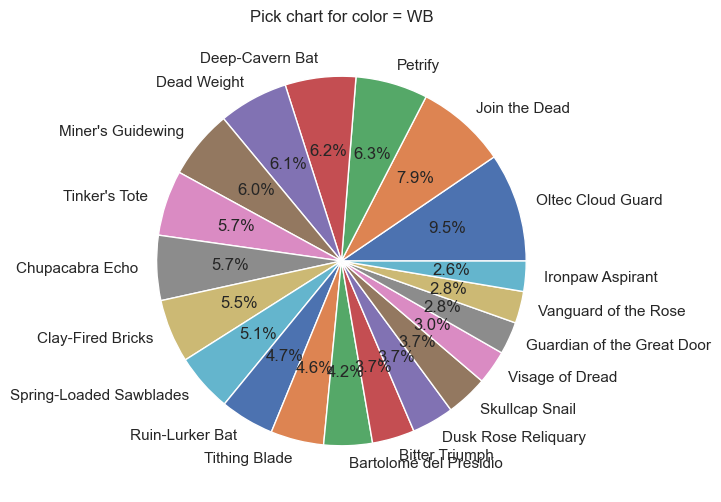

,pick,percentile,rarity,image
0,Oltec Cloud Guard,1.00,common,
1,Join the Dead,0.95,common,
2,Petrify,0.89,common,
3,Deep-Cavern Bat,0.84,uncommon,
4,Dead Weight,0.79,common,
5,Miner's Guidewing,0.74,common,
6,Tinker's Tote,0.68,common,
7,Chupacabra Echo,0.63,uncommon,
8,Ruin-Lurker Bat,0.47,uncommon,
9,Bartolomé del Presidio,0.37,uncommon,


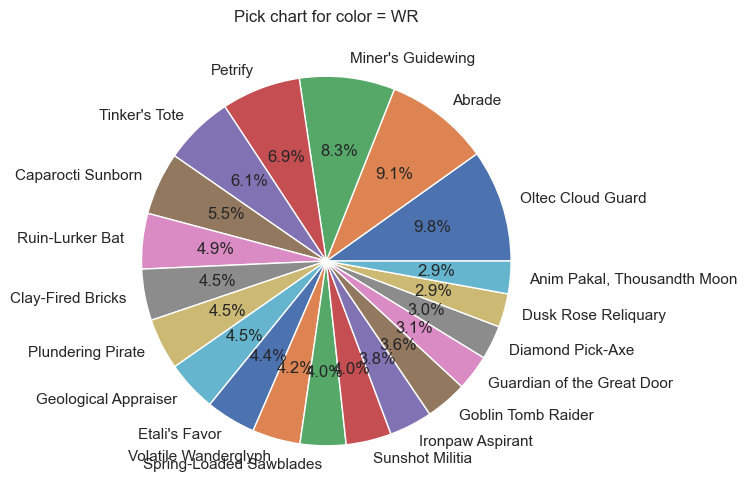

,pick,percentile,rarity,image
0,Oltec Cloud Guard,1.00,common,
1,Abrade,0.95,common,
2,Miner's Guidewing,0.89,common,
3,Petrify,0.84,common,
4,Tinker's Tote,0.79,common,
5,Caparocti Sunborn,0.74,uncommon,
6,Ruin-Lurker Bat,0.68,uncommon,
7,Plundering Pirate,0.58,common,
8,Geological Appraiser,0.53,uncommon,
9,Etali's Favor,0.47,common,


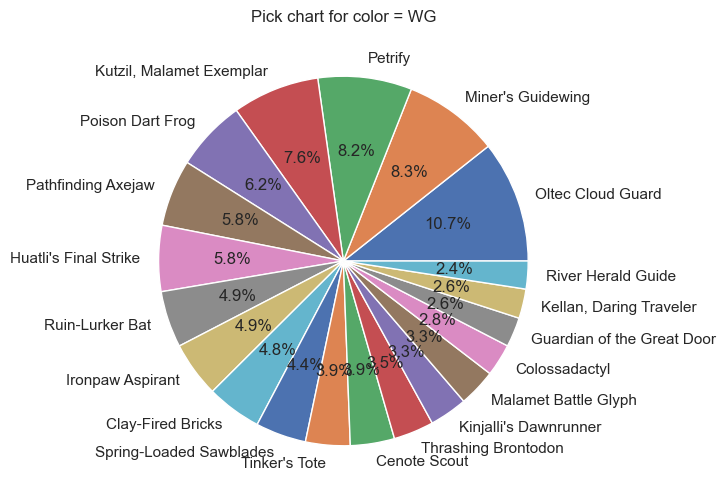

,pick,percentile,rarity,image
0,Oltec Cloud Guard,1.00,common,
1,Miner's Guidewing,0.95,common,
2,Petrify,0.89,common,
3,"Kutzil, Malamet Exemplar",0.84,uncommon,
4,Poison Dart Frog,0.79,common,
5,Pathfinding Axejaw,0.74,common,
6,Huatli's Final Strike,0.68,common,
7,Ruin-Lurker Bat,0.63,uncommon,
8,Ironpaw Aspirant,0.58,common,
9,Tinker's Tote,0.42,common,


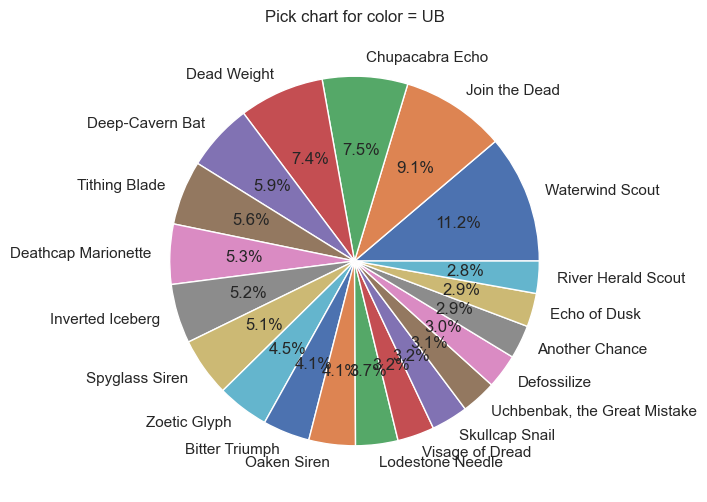

,pick,percentile,rarity,image
0,Waterwind Scout,1.00,common,
1,Join the Dead,0.95,common,
2,Chupacabra Echo,0.89,uncommon,
3,Dead Weight,0.84,common,
4,Deep-Cavern Bat,0.79,uncommon,
5,Deathcap Marionette,0.68,common,
6,Spyglass Siren,0.58,uncommon,
7,Zoetic Glyph,0.53,uncommon,
8,Bitter Triumph,0.47,uncommon,
9,Oaken Siren,0.42,common,


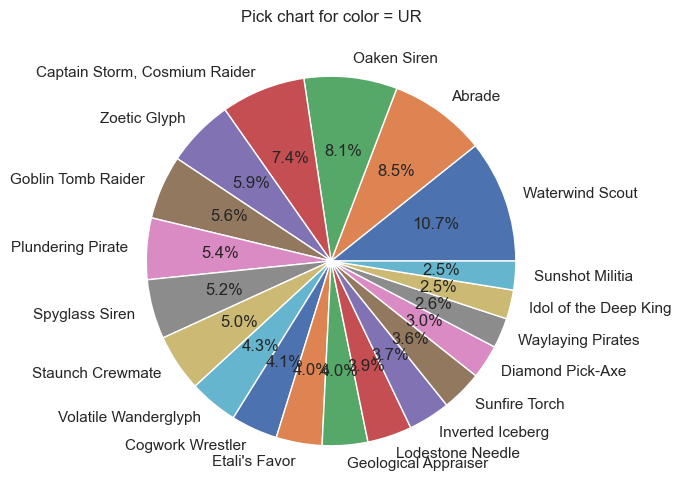

,pick,percentile,rarity,image
0,Waterwind Scout,1.00,common,
1,Abrade,0.95,common,
2,Oaken Siren,0.89,common,
3,"Captain Storm, Cosmium Raider",0.84,uncommon,
4,Zoetic Glyph,0.79,uncommon,
5,Goblin Tomb Raider,0.74,common,
6,Plundering Pirate,0.68,common,
7,Spyglass Siren,0.63,uncommon,
8,Staunch Crewmate,0.58,uncommon,
9,Volatile Wanderglyph,0.53,common,


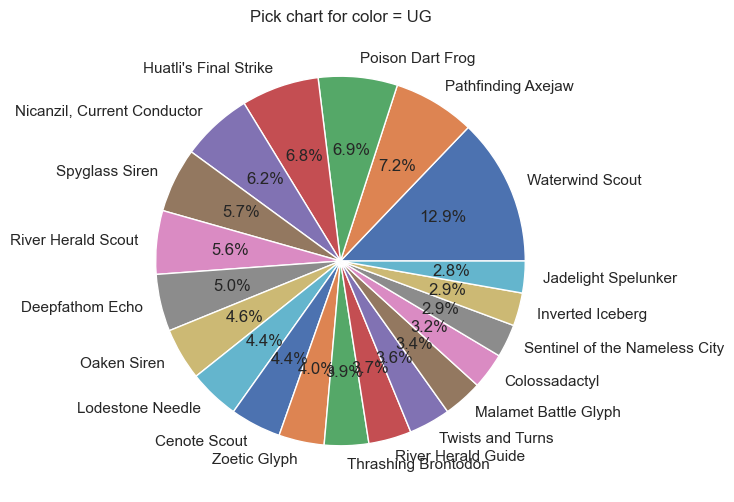

,pick,percentile,rarity,image
0,Waterwind Scout,1.00,common,
1,Pathfinding Axejaw,0.95,common,
2,Poison Dart Frog,0.89,common,
3,Huatli's Final Strike,0.84,common,
4,"Nicanzil, Current Conductor",0.79,uncommon,
5,Spyglass Siren,0.74,uncommon,
6,River Herald Scout,0.68,common,
7,Deepfathom Echo,0.63,rare,
8,Oaken Siren,0.58,common,
9,Cenote Scout,0.47,uncommon,


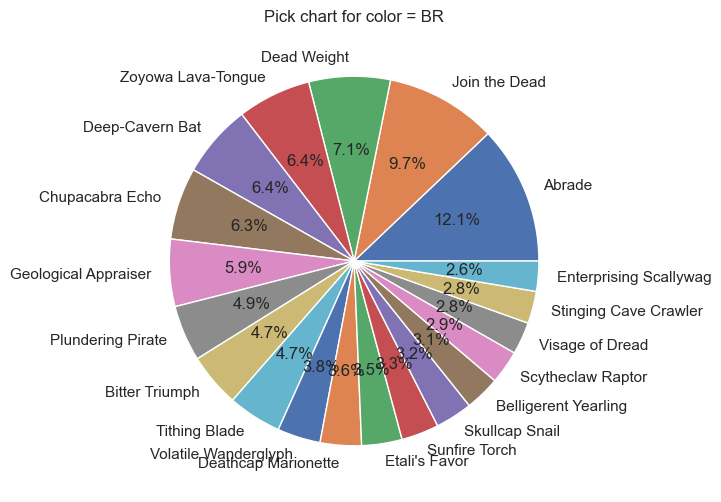

,pick,percentile,rarity,image
0,Abrade,1.00,common,
1,Join the Dead,0.95,common,
2,Dead Weight,0.89,common,
3,Zoyowa Lava-Tongue,0.84,uncommon,
4,Deep-Cavern Bat,0.79,uncommon,
5,Chupacabra Echo,0.74,uncommon,
6,Geological Appraiser,0.68,uncommon,
7,Plundering Pirate,0.63,common,
8,Bitter Triumph,0.58,uncommon,
9,Volatile Wanderglyph,0.47,common,


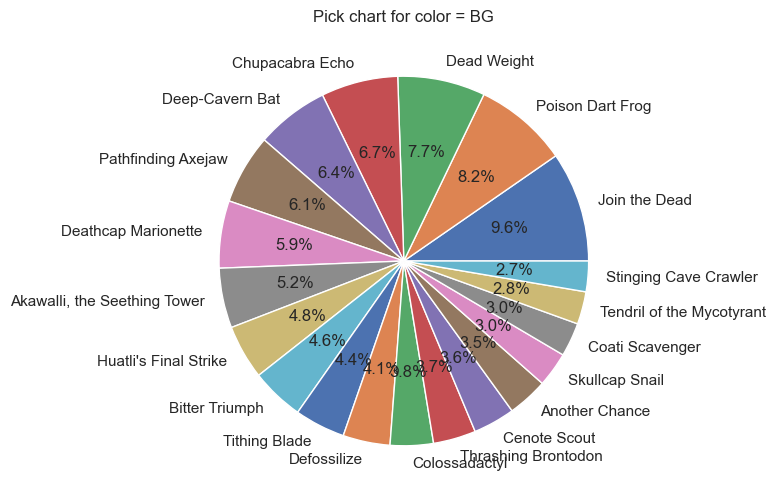

,pick,percentile,rarity,image
0,Join the Dead,1.00,common,
1,Poison Dart Frog,0.95,common,
2,Dead Weight,0.89,common,
3,Chupacabra Echo,0.84,uncommon,
4,Deep-Cavern Bat,0.79,uncommon,
5,Pathfinding Axejaw,0.74,common,
6,Deathcap Marionette,0.68,common,
7,"Akawalli, the Seething Tower",0.63,uncommon,
8,Huatli's Final Strike,0.58,common,
9,Bitter Triumph,0.53,uncommon,


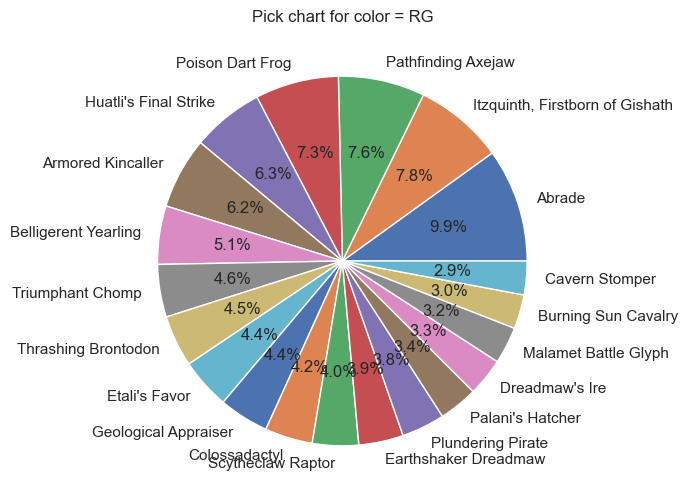

,pick,percentile,rarity,image
0,Abrade,1.00,common,
1,"Itzquinth, Firstborn of Gishath",0.95,uncommon,
2,Pathfinding Axejaw,0.89,common,
3,Poison Dart Frog,0.84,common,
4,Huatli's Final Strike,0.79,common,
5,Armored Kincaller,0.74,common,
6,Belligerent Yearling,0.68,uncommon,
7,Triumphant Chomp,0.63,uncommon,
8,Thrashing Brontodon,0.58,uncommon,
9,Etali's Favor,0.53,common,


In [29]:
from IPython.display import display, HTML, Image
from IPython.utils import io

def url_to_image_html(path):
    return f'<a href="{path}"><img src="{path}" style="max-height:124px;"/>'

def url_website_html(row):
    return f'<a href="{row["scryfall_uri"]}">{row["pick"]}</a>'

result = result_df.copy()
for main_color in custom_sort(result["main_colors"].unique()):
    filtered_data = result[result["main_colors"] == main_color].head(20).copy()
    plt.figure(figsize=(6, 6))
    plt.pie(filtered_data["count"], labels=filtered_data["pick"], autopct="%1.1f%%")
    plt.title(f"Pick chart for color = {main_color}")
    plt.show()
    query = """
SELECT p.pick, percentile, rarity, scryfall_uri, image_uris.large FROM (
    SELECT
        pick, percent_rank() OVER (ORDER BY SUM(count)) AS percentile
    FROM filtered_data
    GROUP BY pick
) AS p
JOIN scryfall_oracle_cards c
ON
    p.pick = c.name
    AND c.set = '{}'
    AND list_contains(games, 'arena')
    AND set_type <> 'promo'
    AND digital = False
    AND promo_types IS NULL
ORDER BY percentile DESC""".format(set_name.lower())
    tmp_result = %sql {{ query }}

    with io.capture_output() as _:
        tmp_result["pick"] = tmp_result.apply(url_website_html, axis=1)
        tmp_result.drop(columns=["scryfall_uri"], inplace=True)
        tmp_result.rename(columns={"large": "image"}, inplace=True)

    display(HTML(f"<H3>Top colors for {main_color}</H3>" + tmp_result.to_html(render_links=True, escape=False, float_format=lambda x: '%10.2f' % x, formatters=dict(image=url_to_image_html))))